## Images Interpolation with Stable Diffusion

_Authored by: [Rustam Akimov](https://github.com/AkiRusProd)_

This notebook shows how to use Stable Diffusion to interpolate between images.  Image interpolation using Stable Diffusion is the process of creating intermediate images that smoothly transition from one given image to another, using a generative model based on diffusion.         

Here are some various use cases for image interpolation with Stable Diffusion:
- Data Augmentation: Stable Diffusion can augment training data for machine learning models by generating synthetic images that lie between existing data points. This can improve the generalization and robustness of machine learning models, especially in tasks like image generation, classification or object detection.   
- Product Design and Prototyping: Stable Diffusion can aid in product design by generating variations of product designs or prototypes with subtle differences. This can be useful for exploring design alternatives, conducting user studies, or visualizing design iterations before committing to physical prototypes.       
- Content Generation for Media Production: In media production, such as film and video editing, Stable Diffusion can be used to generate intermediate frames between key frames, enabling smoother transitions and enhancing visual storytelling. This can save time and resources compared to manual frame-by-frame editing.

In the context of image interpolation, Stable Diffusion models are often used to navigate through a high-dimensional latent space. Each dimension represents a specific feature that has been learned by the model. By walking through this latent space and interpolating between different latent representations of images, the model is able to generate a sequence of intermediate images which show a smooth transition between the original images. There are two types of latents in stable diffusion: prompt latents and image latents.      

Latent space walking involves moving through a latent space along a path defined by two or more points (representing images). By carefully selecting these points and the path between them, it is possible to control the features of the generated images, such as style, content, and other visual aspects.      

In this Notebook, we will explore examples of image interpolation using Stable Diffusion and demonstrate how latent space walking can be implemented and utilized to create smooth transitions between images. We'll provide code snippets and visualizations that illustrate this process in action, allowing for a deeper understanding of how generative models can manipulate and morph image representations in meaningful ways.


First, let's install all the required modules.

In [1]:
# !pip install -q diffusers transformers xformers accelerate
# !pip install -q numpy scipy ftfy Pillow

Import modules

In [2]:
import torch
import numpy as np
import os

import time

from PIL import Image
from IPython import display as IPdisplay
from tqdm.auto import tqdm

from diffusers import StableDiffusionPipeline
from diffusers import (
    DDIMScheduler,
    PNDMScheduler,
    LMSDiscreteScheduler,
    DPMSolverMultistepScheduler,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
)
from transformers import logging

logging.set_verbosity_error()

2025-03-18 15:07:36.506192: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 15:07:36.517578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742310456.530061   49730 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742310456.533628   49730 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 15:07:36.547694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Let's check if CUDA is available.




In [3]:
print(torch.cuda.is_available())

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


These settings are used to optimize the performance of PyTorch models on CUDA-enabled GPUs, especially when using mixed precision training or inference, which can be beneficial in terms of speed and memory usage.       
Source: https://huggingface.co/docs/diffusers/optimization/fp16#memory-efficient-attention

In [4]:
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

### Model

The [`runwayml/stable-diffusion-v1-5`](https://huggingface.co/runwayml/stable-diffusion-v1-5) model and the [`LMSDiscreteScheduler`](https://huggingface.co/docs/diffusers/en/api/schedulers/lms_discrete) scheduler were chosen to generate images. Despite being an older technology, it continues to enjoy popularity due to its fast performance, minimal memory requirements, and the availability of numerous community fine-tuned models built on top of SD1.5. However, you are free to experiment with other models and schedulers to compare the results.

In [5]:
model_name_or_path = "runwayml/stable-diffusion-v1-5"

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)


pipe = StableDiffusionPipeline.from_pretrained(
    model_name_or_path,
    scheduler=scheduler,
    torch_dtype=torch.float32,
).to(device)

# Disable image generation progress bar, we'll display our own
pipe.set_progress_bar_config(disable=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/avika_p/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:221: FutureWarning: The configuration file of this scheduler: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.32.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "steps_offset": 0,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_karras_sigmas": false
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json` file
  deprecate("steps_offset!=1", "

These methods are designed to reduce the memory consumed by the GPU. If you have enough VRAM, you can skip this cell.   

More detailed information can be found here: https://huggingface.co/docs/diffusers/en/optimization/opt_overview     
In particular, information about the following methods can be found here: https://huggingface.co/docs/diffusers/optimization/memory


In [6]:
# Offloading the weights to the CPU and only loading them on the GPU can reduce memory consumption to less than 3GB.
pipe.enable_model_cpu_offload()

# Tighter ordering of memory tensors.
pipe.unet.to(memory_format=torch.channels_last)

# Decoding large batches of images with limited VRAM or batches with 32 images or more by decoding the batches of latents one image at a time.
pipe.enable_vae_slicing()

# Splitting the image into overlapping tiles, decoding the tiles, and then blending the outputs together to compose the final image.
pipe.enable_vae_tiling()

# Using Flash Attention; If you have PyTorch >= 2.0 installed, you should not expect a speed-up for inference when enabling xformers.
pipe.enable_xformers_memory_efficient_attention()


The `display_images` function converts a list of image arrays into a GIF, saves it to a specified path and returns the GIF object for display. It names the GIF file using the current time and handles any errors by printing them out.

In [7]:
def display_images(images, save_path):
    try:
        # Convert each image in the 'images' list from an array to an Image object.
        images = [
            Image.fromarray(np.array(image[0], dtype=np.uint8)) for image in images
        ]

        # Generate a file name based on the current time, replacing colons with hyphens
        # to ensure the filename is valid for file systems that don't allow colons.
        filename = (
            time.strftime("%H:%M:%S", time.localtime())
            .replace(":", "-")
        )
        # Save the first image in the list as a GIF file at the 'save_path' location.
        # The rest of the images in the list are added as subsequent frames to the GIF.
        # The GIF will play each frame for 100 milliseconds and will loop indefinitely.
        images[0].save(
            f"{save_path}/{filename}.gif",
            save_all=True,
            append_images=images[1:],
            duration=100,
            loop=0,
        )
    except Exception as e:
        # If there is an error during the process, print the exception message.
        print(e)

    # Return the saved GIF as an IPython display object so it can be displayed in a notebook.
    return IPdisplay.Image(f"{save_path}/{filename}.gif")

### Generation parameters


* `seed`: This variable is used to set a specific random seed for reproducibility.      
* `generator`: This is set to a PyTorch random number generator object if a seed is provided, otherwise it is None. It ensures that the operations using it have reproducible outcomes.     
* `guidance_scale`: This parameter controls the extent to which the model should follow the prompt in text-to-image generation tasks, with higher values leading to stronger adherence to the prompt.       
* `num_inference_steps`: This specifies the number of steps the model takes to generate an image. More steps can lead to a higher quality image but take longer to generate.        
* `num_interpolation_steps`: This determines the number of steps used when interpolating between two points in the latent space, affecting the smoothness of transitions in generated       animations.        
* `height`: The height of the generated images in pixels.       
* `width`: The width of the generated images in pixels.     
* `save_path`: The file system path where the generated gifs will be saved.       

In [11]:
import os

# Use a writable directory inside WSL (your home directory)
save_path = os.path.expanduser("./output")

if not os.path.exists(save_path):
    os.makedirs(save_path)

print(f"Saving files to: {save_path}")


Saving files to: ./output


In [12]:
# The seed is set to "None", because we want different results each time we run the generation.
seed = None

if seed is not None:
    generator = torch.manual_seed(seed)
else:
    generator = None

# The guidance scale is set to its normal range (7 - 10).
guidance_scale = 8

# The number of inference steps was chosen empirically to generate an acceptable picture within an acceptable time.
num_inference_steps = 15

# The higher you set this value, the smoother the interpolations will be. However, the generation time will increase. This value was chosen empirically.
num_interpolation_steps = 30

# I would not recommend less than 512 on either dimension. This is because this model was trained on 512x512 image resolution.
height = 512
width = 512

# The path where the generated GIFs will be saved
save_path = "./output"

if not os.path.exists(save_path):
    os.makedirs(save_path)


### Example 1: Prompt interpolation

In this example, interpolation between positive and negative prompt embeddings allows exploration of space between two conceptual points defined by prompts, potentially leading to variety of images blending characteristics dictated by prompts gradually. In this case, interpolation involves adding scaled deltas to original embeddings, creating a series of new embeddings that will be used later to generate images with smooth transitions between different states based on the original prompt.


![Example 1](https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/sd_interpolation_1.gif)

First of all, we need to tokenize and obtain embeddings for both positive and negative text prompts. The positive prompt guides the image generation towards the desired characteristics, while the negative prompt steers it away from unwanted features.

In [13]:
# The text prompt that describes the desired output image.
prompt = "Epic shot of Sweden, ultra detailed lake with an ren dear, nostalgic vintage, ultra cozy and inviting, wonderful light atmosphere, fairy, little photorealistic, digital painting, sharp focus, ultra cozy and inviting, wish to be there. very detailed, arty, should rank high on youtube for a dream trip."
# A negative prompt that can be used to steer the generation away from certain features; here, it is empty.
negative_prompt = "poorly drawn,cartoon, 2d, disfigured, bad art, deformed, poorly drawn, extra limbs, close up, b&w, weird colors, blurry"

# The step size for the interpolation in the latent space.
step_size = 0.001

# Tokenizing and encoding the prompt into embeddings.
prompt_tokens = pipe.tokenizer(
    prompt,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
prompt_embeds = pipe.text_encoder(prompt_tokens.input_ids.to(device))[0]


# Tokenizing and encoding the negative prompt into embeddings.
if negative_prompt is None:
    negative_prompt = [""]

negative_prompt_tokens = pipe.tokenizer(
    negative_prompt,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
negative_prompt_embeds = pipe.text_encoder(negative_prompt_tokens.input_ids.to(device))[0]

Now let's look at the code part that generates a random initial vector using a normal distribution that is structured to match the dimensions expected by the diffusion model (UNet). This allows for the reproducibility of the results by optionally using a random number generator. After creating the initial vector, the code performs a series of interpolations between the two embeddings (positive and negative prompts), by incrementally adding a small step size for each iteration. The results are stored in a list named "walked_embeddings".

In [14]:
# Generating initial latent vectors from a random normal distribution, with the option to use a generator for reproducibility.
latents = torch.randn(
    (1, pipe.unet.config.in_channels, height // 8, width // 8),
    generator=generator,
)

walked_embeddings = []

# Interpolating between embeddings for the given number of interpolation steps.
for i in range(num_interpolation_steps):
    walked_embeddings.append(
        [prompt_embeds + step_size * i, negative_prompt_embeds + step_size * i]
    )

Finally, let's generate a series of images based on interpolated embeddings and then displaying these images. We'll iterate over an array of embeddings, using each to generate an image with specified characteristics like height, width, and other parameters relevant to image generation. Then we'll collect these images into a list. Once generation is complete we'll call the `display_image` function to save and display these images as GIF at a given save path.

  0%|          | 0/30 [00:00<?, ?it/s]

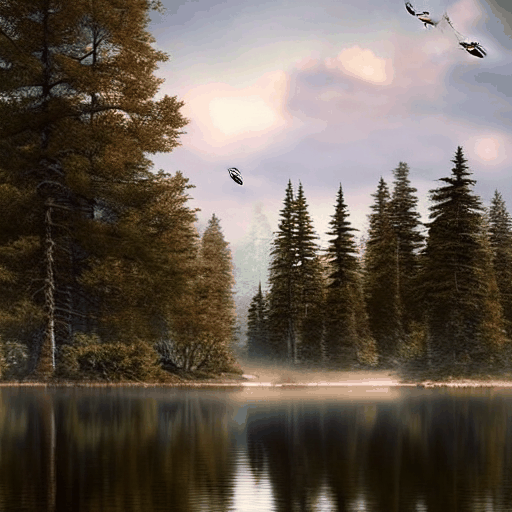

In [15]:
# Generating images using the interpolated embeddings.
images = []
for latent in tqdm(walked_embeddings):
    images.append(
        pipe(
            height=height,
            width=width,
            num_images_per_prompt=1,
            prompt_embeds=latent[0],
            negative_prompt_embeds=latent[1],
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator,
            latents=latents,
        ).images
    )

# Display of saved generated images.
display_images(images, save_path)

### Example 2: Diffusion latents interpolation for a single prompt
Unlike the first example, in this one, we are performing interpolation between the two embeddings of the diffusion model itself, not the prompts. Please note that in this case, we use the slerp function for interpolation. However, there is nothing stopping us from adding a constant value to one embedding instead.


![Example 2](https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/sd_interpolation_2.gif)

The function presented below stands for Spherical Linear Interpolation. It is a method of interpolation on the surface of a sphere. This function is commonly used in computer graphics to animate rotations in a smooth manner and can also be used to interpolate between high-dimensional data points in machine learning, such as latent vectors used in generative models.       

The source is from Andrej Karpathy's gist: https://gist.github.com/karpathy/00103b0037c5aaea32fe1da1af553355.        
A more detailed explanation of this method can be found at: https://en.wikipedia.org/wiki/Slerp.

In [16]:
def slerp(v0, v1, num, t0=0, t1=1):
    v0 = v0.detach().cpu().numpy()
    v1 = v1.detach().cpu().numpy()

    def interpolation(t, v0, v1, DOT_THRESHOLD=0.9995):
        """helper function to spherically interpolate two arrays v1 v2"""
        dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
        if np.abs(dot) > DOT_THRESHOLD:
            v2 = (1 - t) * v0 + t * v1
        else:
            theta_0 = np.arccos(dot)
            sin_theta_0 = np.sin(theta_0)
            theta_t = theta_0 * t
            sin_theta_t = np.sin(theta_t)
            s0 = np.sin(theta_0 - theta_t) / sin_theta_0
            s1 = sin_theta_t / sin_theta_0
            v2 = s0 * v0 + s1 * v1
        return v2

    t = np.linspace(t0, t1, num)

    v3 = torch.tensor(np.array([interpolation(t[i], v0, v1) for i in range(num)]))

    return v3

In [ ]:
# The text prompt that describes the desired output image.
prompt = "Sci-fi digital painting of an alien landscape with otherworldly plants, strange creatures, and distant planets."
# A negative prompt that can be used to steer the generation away from certain features.
negative_prompt = "poorly drawn,cartoon, 3d, disfigured, bad art, deformed, poorly drawn, extra limbs, close up, b&w, weird colors, blurry"

# Generating initial latent vectors from a random normal distribution. In this example two latent vectors are generated, which will serve as start and end points for the interpolation.
# These vectors are shaped to fit the input requirements of the diffusion model's U-Net architecture.
latents = torch.randn(
    (2, pipe.unet.config.in_channels, height // 8, width // 8),
    generator=generator,
)

# Getting our latent embeddings
interpolated_latents = slerp(latents[0], latents[1], num_interpolation_steps)

# Generating images using the interpolated embeddings.
images = []
for latent_vector in tqdm(interpolated_latents):
    images.append(
        pipe(
            prompt,
            height=height,
            width=width,
            negative_prompt=negative_prompt,
            num_images_per_prompt=1,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator,
            latents=latent_vector[None, ...].to(torch.float32).to(device),
        ).images
    )

# Display of saved generated images.
display_images(images, save_path)

  0%|          | 0/30 [00:00<?, ?it/s]

### Example 3: Interpolation between multiple prompts

In contrast to the first example, where we moved away from a single prompt, in this example, we will be interpolating between any number of prompts. To do so, we will take consecutive pairs of prompts and create smooth transitions between them. Then, we will combine the interpolations of these consecutive pairs, and instruct the model to generate images based on them. For interpolation we will use the slerp function, as in the second example.

![Example 3](https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/sd_interpolation_3.gif)

Once again, let's tokenize and obtain embeddings but this time for multiple positive and negative text prompts.

In [ ]:
# Text prompts that describes the desired output image.
prompts = [
    "A cute dog in a beautiful field of lavander colorful flowers everywhere, perfect lighting, leica summicron 35mm f2.0, kodak portra 400, film grain",
    "A cute cat in a beautiful field of lavander colorful flowers everywhere, perfect lighting, leica summicron 35mm f2.0, kodak portra 400, film grain",
]
# Negative prompts that can be used to steer the generation away from certain features.
negative_prompts = [
    "poorly drawn,cartoon, 2d, sketch, cartoon, drawing, anime, disfigured, bad art, deformed, poorly drawn, extra limbs, close up, b&w, weird colors, blurry",
    "poorly drawn,cartoon, 2d, sketch, cartoon, drawing, anime, disfigured, bad art, deformed, poorly drawn, extra limbs, close up, b&w, weird colors, blurry",
]

# NOTE: The number of prompts must match the number of negative prompts

batch_size = len(prompts)

# Tokenizing and encoding prompts into embeddings.
prompts_tokens = pipe.tokenizer(
    prompts,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
prompts_embeds = pipe.text_encoder(
    prompts_tokens.input_ids.to(device)
)[0]

# Tokenizing and encoding negative prompts into embeddings.
if negative_prompts is None:
    negative_prompts = [""] * batch_size

negative_prompts_tokens = pipe.tokenizer(
    negative_prompts,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
negative_prompts_embeds = pipe.text_encoder(
    negative_prompts_tokens.input_ids.to(device)
)[0]

As stated earlier, we will take consecutive pairs of prompts and create smooth transitions between them with `slerp` function.

In [ ]:
# Generating initial U-Net latent vectors from a random normal distribution.
latents = torch.randn(
    (1, pipe.unet.config.in_channels, height // 8, width // 8),
    generator=generator,
)

# Interpolating between embeddings pairs for the given number of interpolation steps.
interpolated_prompt_embeds = []
interpolated_negative_prompts_embeds = []
for i in range(batch_size - 1):
    interpolated_prompt_embeds.append(
        slerp(
            prompts_embeds[i],
            prompts_embeds[i + 1],
            num_interpolation_steps
        )
    )
    interpolated_negative_prompts_embeds.append(
        slerp(
            negative_prompts_embeds[i],
            negative_prompts_embeds[i + 1],
            num_interpolation_steps,
        )
    )

interpolated_prompt_embeds = torch.cat(
    interpolated_prompt_embeds, dim=0
).to(device)

interpolated_negative_prompts_embeds = torch.cat(
    interpolated_negative_prompts_embeds, dim=0
).to(device)

Finally, we need to generate images based on the embeddings.

In [ ]:
# Generating images using the interpolated embeddings.
images = []
for prompt_embeds, negative_prompt_embeds in tqdm(
    zip(interpolated_prompt_embeds, interpolated_negative_prompts_embeds),
    total=len(interpolated_prompt_embeds),
):
    images.append(
        pipe(
            height=height,
            width=width,
            num_images_per_prompt=1,
            prompt_embeds=prompt_embeds[None, ...],
            negative_prompt_embeds=negative_prompt_embeds[None, ...],
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator,
            latents=latents,
        ).images
    )

# Display of saved generated images.
display_images(images, save_path)

### Example 4: Circular walk through the diffusion latent space for a single prompt

This example was taken from: https://keras.io/examples/generative/random_walks_with_stable_diffusion/       

Let's imagine that we have two noise components, which we'll call x and y. We start by moving from 0 to 2π and at each step we add the cosine of x and the sine of y to the result. Using this approach, at the end of our movement we end up with the same noise values ​​that we started with. This means that vectors end up turning into themselves, ending our movement.



![Example 4](https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/sd_interpolation_4.gif)

In [ ]:
# The text prompt that describes the desired output image.
prompt = "Beautiful sea sunset, warm light, Aivazovsky style"
# A negative prompt that can be used to steer the generation away from certain features
negative_prompt = "picture frames"

# Generating initial latent vectors from a random normal distribution to create a loop interpolation between them.
latents = torch.randn(
    (2, 1, pipe.unet.config.in_channels, height // 8, width // 8),
    generator=generator,
)


# Calculation of looped embeddings
walk_noise_x = latents[0].to(device)
walk_noise_y = latents[1].to(device)

# Walking on a trigonometric circle
walk_scale_x = torch.cos(torch.linspace(0, 2, num_interpolation_steps) * np.pi).to(
    device
)
walk_scale_y = torch.sin(torch.linspace(0, 2, num_interpolation_steps) * np.pi).to(
    device
)

# Applying interpolation to noise
noise_x = torch.tensordot(walk_scale_x, walk_noise_x, dims=0)
noise_y = torch.tensordot(walk_scale_y, walk_noise_y, dims=0)

circular_latents = noise_x + noise_y

# Generating images using the interpolated embeddings.
images = []
for latent_vector in tqdm(circular_latents):
    images.append(
        pipe(
            prompt,
            height=height,
            width=width,
            negative_prompt=negative_prompt,
            num_images_per_prompt=1,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator,
            latents=latent_vector,
        ).images
    )

# Display of saved generated images.
display_images(images, save_path)

## Next Steps       
Moving forward, you can explore various parameters such as guidance scale, seed, and number of interpolation steps to observe how they affect the generated images. Additionally, consider trying out different prompts and schedulers to further enhance your results. Another valuable step would be to implement linear interpolation (`linspace`) instead of spherical linear interpolation (`slerp`) and compare the results to gain deeper insights into the interpolation process.